# Testing Spin Tracking the Standard Way

This is similar to the other QuaternionTesting notebook except I'm focussing entirely on spin tracking in particular. 

Goal is to see if one method is faster or more precise than the other in a constant magnetic field.

In [1]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.integrate
import tqdm
import time

In [2]:
@numba.jit
def qMult(q1, q2):
	w1, x1, y1, z1 = q1
	w2, x2, y2, z2 = q2
	w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
	x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
	y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
	z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
	return np.array([w, x, y, z], dtype=q1.dtype)

@numba.jit
def eulerToQuaternion(phi, theta, psi):
	qw = np.cos(phi/2) * np.cos(theta/2) * np.cos(psi/2) + np.sin(phi/2) * np.sin(theta/2) * np.sin(psi/2)
	qx = np.sin(phi/2) * np.cos(theta/2) * np.cos(psi/2) - np.cos(phi/2) * np.sin(theta/2) * np.sin(psi/2)
	qy = np.cos(phi/2) * np.sin(theta/2) * np.cos(psi/2) + np.sin(phi/2) * np.cos(theta/2) * np.sin(psi/2)
	qz = np.cos(phi/2) * np.cos(theta/2) * np.sin(psi/2) - np.sin(phi/2) * np.sin(theta/2) * np.cos(psi/2)
	return [qw, qx, qy, qz]

@numba.jit
def quaternionToEuler(w, x, y, z):
	t0 = 2 * (w * x + y * z)
	t1 = 1 - 2 * (x * x + y * y)
	X = np.atan2(t0, t1)
	t2 = 2 * (w * y - z * x)
	t2 = 1 if t2 > 1 else t2
	t2 = -1 if t2 < -1 else t2
	Y = np.asin(t2)
	t3 = 2 * (w * z + x * y)
	t4 = 1 - 2 * (y * y + z * z)
	Z = np.atan2(t3, t4)
	return X, Y, Z

@numba.jit
def cross(x, y):
	return np.array( (x[1]*y[2] - x[2]*y[1], x[2]*y[0] - x[0]*y[2], x[0]*y[1] - x[1]*y[0]))

@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def norm(a):
	return a/vecLen(a)

@numba.jit
def calcGamma(v):
	return 1.0/np.sqrt(1-(v/299792458.0)**2.0)

@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def vecNorm(a):
	return a/vecLen(a)

@numba.jit
def BMTCross(t, s, x, v, a, B, E, consts):
	crossVal = 0
	B0 = B(t)
	E0 = E(t)
	if vecLen(v) < 10.0: #the non-relativistic case
		BPrime = B0 -1.0/89875517873681764.0*np.cross(v, E0)
		wt = 1.0/(89875517873681764.0*2.0)*np.cross(a, v)
		crossVal = -2.0*consts['mu']/(consts['hbar'])*BPrime + wt
	else:#allow for relativity even though it's probably not going to do anything at this scale
		gamma = calcGamma(vecLen(v))
		BPrime = gamma*B0+(1-gamma)*(np.dot(B0, v))*v/vecLen(v)**2.0 - gamma/89875517873681764.0*np.cross(v, E0)
		wt = gamma**2.0 / (89875517873681764.0*(gamma+1))*np.cross(a, v)
		#update the spin
		crossVal = -2.0*consts['mu']/(gamma*consts['hbar'])*BPrime + wt
	return crossVal

@numba.jit
def determineMatrix(s):
	return np.array([[0, -s[2], s[1]], [s[2], 0, -s[0]], [-s[1], s[0], 0]])

@numba.jit
def determineQuatMatrix(s):
	return -0.5 * np.array([[0, s[2], -s[1], s[0]],
							[-s[2], 0, s[0], s[1]],
							[s[1], -s[0], 0, s[2]],
							[-s[0], -s[1], -s[2], 0]])

@numba.jit
def rodriguez(k, dt):
	norm = vecNorm(k) #normalized vector
	angle = vecLen(k) #the angle of rotation for 1 second of spin precession
	K = determineMatrix(norm) #calculate the matrix from this vector
	h = angle*dt
	return np.identity(3)+np.sin(h)*K+(1-np.cos(h))*np.dot(K, K)

@numba.jit
def oneStepForward(t, dt, s, x, v, a, B, E, consts):
	crossVal = BMTCross(t, s, x, v, a, B, E, consts)
	rotation = rodriguez(crossVal, dt)
	return np.dot(rotation, s)

@numba.jit
def normalMethod(t, s, x, v, a, B, E, consts):
	crossVal = BMTCross(t, s, x, v, a, B, E, consts)
	return np.cross(crossVal, s)

@numba.jit

## First do Spin Tracking the Standard Way

Neutron in a constant magnetic field, nothing too crazy

In [3]:
def updateSpinStandard(tStep, s, v, B, E, consts):
	if tStep != 0:
		
		s = norm(s)
		#this is the base iteration function, the idea is to shift all the values by one step each time this is called
		B = B0+np.cross(E0, v/89875517873681764.0) #big number is the speed of light squared in m^2/s^2
		#update the spin
		crossVal = consts['gamma']*B+2.0*(consts['dn']/consts['hbar'])*E0
		s = np.cross(s, crossVal)
	return s

In [4]:
precision = np.float64
neutType = np.dtype([('x', precision, 3), ('v', precision, 3), ('s', precision, 3)])

constType = np.dtype([('m', precision), ('dn', precision), ('gamma', precision), ('hbar', precision)])
consts = np.array(1, dtype=constType)
consts['m']=1.674927485E-27 #units of kg
consts['dn'] = 0.0
consts['gamma'] = -1.83247171E8
consts['hbar'] = 1.054571817E-34

#E = np.array([0, 0, 75.0E5], dtype=precision)
E = np.array([0, 0, 0], dtype=precision)
B = np.array([0, 0, 30.0E-8], dtype=precision)

In [28]:
timeStop = 1000.0
neuts = np.zeros(1, dtype=neutType)
neut = neuts[0]
neut['s'] = np.array([1.0, 0.0, 0.0])
neut['v'] = [0.0, 0.0, 0.0]

#rk23 and BDF are not used due to taking absolutely forever

max_step = 0.001
first_step = 0.0001

In [29]:
start = time.time()
resDOP = scipy.integrate.solve_ivp(updateSpin, (0.0, timeStop), neut['s'][:], method='DOP853', args=(neut['v'], B, E, consts), max_step = max_step, first_step = first_step)
print(time.time()-start)

119.93469500541687


In [30]:
start = time.time()
resRK45 = scipy.integrate.solve_ivp(updateSpin, (0.0, timeStop), neut['s'][:], method='RK45', args=(neut['v'], B, E, consts), max_step = max_step, first_step = first_step)
print(time.time()-start)

72.05276989936829


In [31]:
start = time.time()
resLSODA = scipy.integrate.solve_ivp(updateSpin, (0.0, timeStop), neut['s'][:], method='LSODA', args=(neut['v'], B, E, consts), max_step = max_step, first_step = first_step)
print(time.time()-start)

14.098659992218018


In [32]:
start = time.time()
resRadau = scipy.integrate.solve_ivp(updateSpin, (0.0, timeStop), neut['s'][:], method='Radau', args=(neut['v'], B, E, consts), max_step = max_step, first_step = first_step)
print(time.time()-start)

263.46726059913635


In [57]:
timeScale = np.arange(0, timeStop, 0.001)
w = consts['gamma']*vecLen(B)
trueSolutionX = np.cos(w*timeScale)
trueSolutionY = -1*np.sin(w*timeScale)

In [34]:
neuts = np.zeros(1, dtype=neutType)
neut = neuts[0]
neut['s'] = np.array([1.0, 0.0, 0.0])
neut['v'] = [0.0, 0.0, 0.0]
manualRes = manualIntegration(np.copy(neut), B, E, consts, timeStop, 0.0001)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [00:34<00:00, 289713.70it/s]


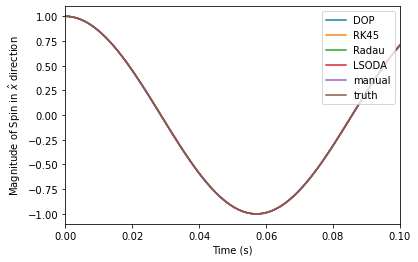

In [37]:
plt.plot(resDOP.t, resDOP.y[0,:], label='DOP')
plt.plot(resRK45.t, resRK45.y[0,:], label='RK45')
plt.plot(resRadau.t, resRadau.y[0,:], label='Radau')
plt.plot(resLSODA.t, resLSODA.y[0,:], label='LSODA')
plt.plot(manualRes[1], manualRes[2][:,0], label='manual')
plt.plot(timeScale, trueSolutionX, label='truth')
plt.xlim(0, 0.1)
plt.xlabel('Time (s)')
plt.ylabel(r'Magnitude of Spin in $\hat{x}$ direction')
plt.legend(loc='upper right')
plt.show()

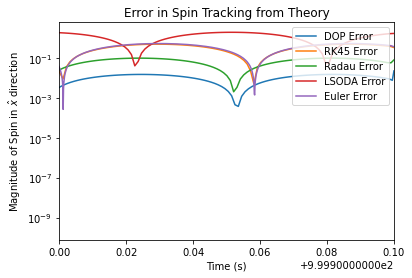

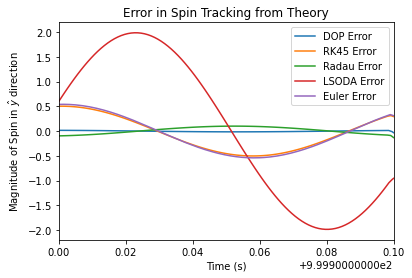

In [62]:
plt.plot(resDOP.t, abs(resDOP.y[0,:] - np.interp(resDOP.t, timeScale, trueSolutionX)), label='DOP Error')
plt.plot(resRK45.t, abs(resRK45.y[0,:] - np.interp(resRK45.t, timeScale, trueSolutionX)), label='RK45 Error')
plt.plot(resRadau.t, abs(resRadau.y[0,:] - np.interp(resRadau.t, timeScale, trueSolutionX)), label='Radau Error')
plt.plot(resLSODA.t, abs(resLSODA.y[0,:] - np.interp(resLSODA.t, timeScale, trueSolutionX)), label='LSODA Error')
plt.plot(manualRes[1], abs(manualRes[2][:,0] - np.interp(manualRes[1], timeScale, trueSolutionX)), label='Euler Error')
plt.xlim(999.9, 1000
plt.xlabel('Time (s)')
plt.ylabel(r'Magnitude of Spin in $\hat{x}$ direction')
plt.legend(loc='upper right')
plt.title('Error in Spin Tracking from Theory')
plt.yscale('log')
plt.show()

plt.plot(resDOP.t, resDOP.y[1,:] - np.interp(resDOP.t, timeScale, trueSolutionY), label='DOP Error')
plt.plot(resRK45.t, resRK45.y[1,:] - np.interp(resRK45.t, timeScale, trueSolutionY), label='RK45 Error')
plt.plot(resRadau.t, resRadau.y[1,:] - np.interp(resRadau.t, timeScale, trueSolutionY), label='Radau Error')
plt.plot(resLSODA.t, resLSODA.y[1,:] - np.interp(resLSODA.t, timeScale, trueSolutionY), label='LSODA Error')
plt.plot(manualRes[1], manualRes[2][:,1] - np.interp(manualRes[1], timeScale, trueSolutionY), label='Euler Error')
plt.xlim(999.9, 1000)
plt.xlabel('Time (s)')
plt.ylabel(r'Magnitude of Spin in $\hat{y}$ direction')
plt.legend(loc='upper right')
plt.title('Error in Spin Tracking from Theory')
plt.show()

#plt.plot(resRK45.t, resRK45.y[0,:], label='RK45')
#plt.plot(resRadau.t, resRadau.y[0,:], label='Radau')
#plt.plot(resLSODA.t, resLSODA.y[0,:], label='LSODA')
#plt.plot(manualRes[1], manualRes[2][:,0], label='manual')
#plt.plot(timeScale, trueSolutionX, label='truth')


In [31]:
sizes = np.arange(0.00005, 0.00012, 0.00001)
results = []
tracks = []
times = []
for val in sizes:
	neuts = np.zeros(1, dtype=neutType)
	neut = neuts[0]
	neut['s'] = np.array([1.0, 0.0, 0.0])
	neut['v'] = [0.0, 0.0, 0.0]
	res = manualIntegration(neut, B, E, consts, 1000, val)
	times.append(res[1])
	tracks.append(res[2])
	results.append(res[0])

100%|█████████████████████████████████████████████████████████████████████| 9090909/9090909 [00:26<00:00, 339558.94it/s]


In [32]:
for i in range(len(sizes)):
	print(times[i], tracks[i][0,2])

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


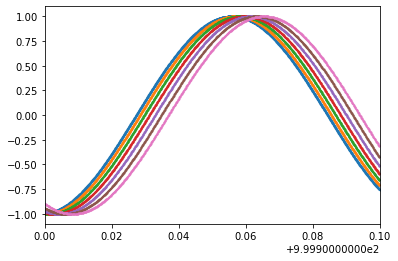

In [38]:
for i in range(len(sizes)):
	plt.scatter(times[i], tracks[i][:,0], s=1)
plt.xlim(999.9, 1000)
plt.show()

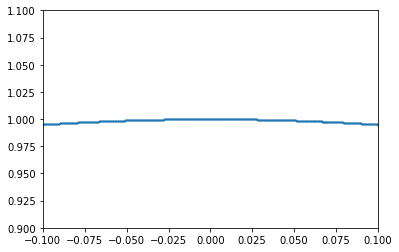

In [40]:
plt.scatter(steps['s'][:,0], steps['s'][:,1], s = 0.1)
plt.xlim(-0.1, 0.1)
plt.ylim(0.9, 1.1)
plt.show()

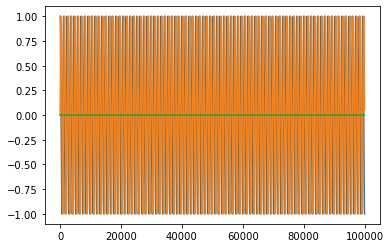

In [25]:
plt.plot(ss[:,0])
plt.plot(ss[:,1])
plt.plot(ss[:,2])

In [7]:
testDataset = np.arange(22*24)

In [12]:
testDataset.shape

(528,)

In [28]:
fancyShape = testDataset.reshape()
print(fancyShape.shape)

ValueError: cannot reshape array of size 528 into shape (22,)

In [15]:
fancyShape.mean(axis=1)

array([ 11.5,  35.5,  59.5,  83.5, 107.5, 131.5, 155.5, 179.5, 203.5,
       227.5, 251.5, 275.5, 299.5, 323.5, 347.5, 371.5, 395.5, 419.5,
       443.5, 467.5, 491.5, 515.5])